Importing necessary libraries


In [45]:
import tensorflow as tf

%matplotlib inline
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd

import matplotlib.patches as patches 

import json
import re
import glob
import matplotlib.image as mpimg

from tensorflow.keras import layers

import cv2

Extractitng data

In [3]:
def spliter(line):
    line = re.split(">", line)
    line = re.split("<", line[1])
    return(line[0])


def create_dataframe(directory_path):
    """
    function that creates a dataframe countaining two columns: ImageId and ImageBoxes
    ImageId is the name of the image (not the path)
    ImageBoxes is a list containing a list for every element spotted in the image arrange in that way:
    [className, xmin, ymin, xmax, ymax]
    """
    
    JPG_counter = len(glob.glob1(directory_path,"*.jpg"))
    XML_counter = len(glob.glob1(directory_path,"*.xml"))
    assert JPG_counter == XML_counter, "jpg and xml are not the same length"
    
    image_boxes_list, image_id_list = [], []
    for dirname, _, filenames in os.walk(directory_path):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".xml"):
                f = open(path, 'r')
                image_boxes = []
                for element in f:
                    if "<name>" in element:
                        image_boxes.append(spliter(element))
                    if "<xmin>" in element:
                        image_boxes.append(int(spliter(element)))
                    if "<ymin>" in element:
                        image_boxes.append(int(spliter(element)))
                    if "<xmax>" in element:
                        image_boxes.append(int(spliter(element)))
                    if "<ymax>" in element:
                        image_boxes.append(int(spliter(element)))
                image_id_list.append(filename.split('.')[0])
                image_boxes_list.append(image_boxes)
    df = pd.DataFrame(list(zip(image_id_list, image_boxes_list)),columns =['ImageId', 'ImageBoxes'])
    return(df)

training_directory_path = '/kaggle/input/fruit-images-for-object-detection/train_zip/train'
testing_directory_path = '/kaggle/input/fruit-images-for-object-detection/test_zip/test'

df_train, df_test = create_dataframe(training_directory_path), create_dataframe(testing_directory_path)


In [4]:
df_train

,ImageId,ImageBoxes
0,apple_28,"[apple, 25, 42, 275, 297]"
1,orange_22,"[orange, 75, 96, 531, 465]"
2,apple_65,"[apple, 70, 25, 290, 226, apple, 35, 217, 253,..."
3,orange_41,"[orange, 390, 391, 815, 800]"
4,banana_67,"[banana, 19, 21, 337, 325]"
...,...,...
235,apple_27,"[apple, 51, 3, 414, 350]"
236,apple_63,"[apple, 19, 1, 719, 708]"
237,banana_64,"[banana, 132, 98, 591, 348]"
238,orange_53,"[orange, 324, 291, 692, 680]"


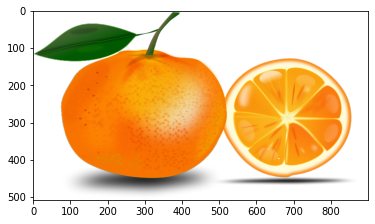

In [5]:
one_image_path = "/kaggle/input/fruit-images-for-object-detection/train_zip/train/"+"orange_22"+'.jpg'
image = mpimg.imread(one_image_path)
imgplot = plt.imshow(image)
plt.show()

In [9]:
def tfmbb(bb,h,w):
    bb_=[]
    bb_.append((bb[0]/w))
    bb_.append((bb[1]/h))
    bb_.append((bb[2]/w))
    bb_.append((bb[3]/h))
    return bb_
    
    

In [ ]:
df_train.size

Dropping data with multiple bbox

In [11]:
def drop_multis(df):
    l=[]
    for i in range(0,df.shape[0]):
        x=df.iloc[i]
        if len(x['ImageBoxes'])>5:
            l.append(i)
    return l
   

    

In [12]:
l=drop_multis(df_train)

In [13]:
df_train=df_train.drop(l)

In [14]:
l=drop_multis(df_test)

In [15]:
df_test=df_test.drop(l)

In [16]:
df_test

,ImageId,ImageBoxes
0,banana_84,"[banana, 85, 138, 553, 352]"
2,banana_77,"[banana, 29, 11, 246, 348]"
3,apple_82,"[apple, 65, 122, 365, 404]"
5,orange_80,"[orange, 150, 165, 923, 983]"
9,apple_85,"[apple, 88, 41, 415, 393]"
13,orange_91,"[orange, 166, 92, 638, 559]"
14,orange_82,"[orange, 61, 130, 415, 473]"
16,orange_95,"[orange, 146, 361, 1112, 1254]"
17,apple_91,"[apple, 227, 62, 723, 500]"
18,orange_84,"[orange, 145, 36, 421, 286]"


In [20]:
train_labels=[]
train_boxes=[]
for i in range(df_train.shape[0]):
    
    x=df_train.iloc[i]["ImageBoxes"]
    train_labels.append(classes.index(x[0]))
    train_boxes.append(x[1:])
    

In [19]:
test_labels=[]
test_boxes=[]
for i in range(df_test.shape[0]):
    
    x=df_test.iloc[i]["ImageBoxes"]
    test_labels.append(classes.index(x[0]))
    test_boxes.append(x[1:])
    

In [18]:
classes=['apple','orange','banana']

In [21]:
def get_size(imgId):
    img_path="/kaggle/input/fruit-images-for-object-detection/train_zip/train/"+imgId+'.jpg'
    img=cv2.imread(img_path)
    width=img.shape[1]
    height=img.shape[0]
    return height,width

                   
    
    

In [22]:
def get_size_test(imgId):
    img_path="/kaggle/input/fruit-images-for-object-detection/test_zip/test/"+imgId+'.jpg'
    img=cv2.imread(img_path)
    width=img.shape[1]
    height=img.shape[0]
    return height,width


In [23]:
train_boxes1=[]
for i in range(len(train_boxes)):
    x=df_train.iloc[i]["ImageId"]
    h=get_size(x)[0]
    w=get_size(x)[1]
    train_boxes1.append(tfmbb(train_boxes[i],h,w))
    

In [24]:
test_boxes1=[]
for i in range(len(test_boxes)):
    x=df_test.iloc[i]["ImageId"]
    h=get_size_test(x)[0]
    w=get_size_test(x)[1]
    test_boxes1.append(tfmbb(test_boxes[i],h,w))

In [25]:
test_boxes1

[[0.13076923076923078,
  0.3770491803278688,
  0.8507692307692307,
  0.9617486338797814],
 [0.09666666666666666, 0.030555555555555555, 0.82, 0.9666666666666667],
 [0.15625, 0.25957446808510637, 0.8774038461538461, 0.8595744680851064],
 [0.1, 0.14666666666666667, 0.6153333333333333, 0.8737777777777778],
 [0.176, 0.1025, 0.83, 0.9825],
 [0.2075, 0.13609467455621302, 0.7975, 0.8269230769230769],
 [0.09384615384615384,
  0.19969278033794163,
  0.6384615384615384,
  0.7265745007680492],
 [0.10735294117647058,
  0.26159420289855073,
  0.8176470588235294,
  0.908695652173913],
 [0.23645833333333333, 0.1082024432809773, 0.753125, 0.8726003490401396],
 [0.31521739130434784, 0.1, 0.9152173913043479, 0.7944444444444444],
 [0.18615384615384614,
  0.35384615384615387,
  0.7407692307692307,
  0.9453846153846154],
 [0.00125, 0.0013422818791946308, 0.9925, 0.9906040268456375],
 [0.02857142857142857, 0.022857142857142857, 0.9828571428571429, 0.96],
 [0.25833333333333336, 0.21, 0.755, 0.872],
 [0.446153

In [26]:
train_imgs=[]
height=224
width=224
for i in range(df_train.shape[0]):
    x=df_train.iloc[i]["ImageId"]
    img_path="/kaggle/input/fruit-images-for-object-detection/train_zip/train/"+x+'.jpg'
    train_img =load_img(img_path, target_size=(height, width))
    train_imgs.append(img_to_array(train_img))

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [27]:
test_imgs=[]
height=224
width=224
for i in range(df_test.shape[0]):
    x=df_test.iloc[i]["ImageId"]
    img_path="/kaggle/input/fruit-images-for-object-detection/test_zip/test/"+x+'.jpg'
    test_img =load_img(img_path, target_size=(height, width))
    test_imgs.append(img_to_array(test_img))

In [28]:
train_imgs=np.array(train_imgs)
train_labels=np.array(train_labels)
train_boxes=np.array(train_boxes1)

test_imgs=np.array(test_imgs)
test_labels=np.array(test_labels)
test_boxes=np.array(test_boxes1)


In [36]:
input_shape = (height, width, 3)
input_layer = layers.Input(input_shape)

#create the base layers
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

2021-10-30 20:29:58.685385: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-30 20:29:58.688659: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-30 20:29:58.734474: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 20:29:58.735097: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-30 20:29:58.735148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-30 20:29:58.760917: I tensorflow/stream_executor/platform/def

In [37]:
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(3, name='cl_head')(classifier_branch)

In [40]:
bboxHead = Dense(128, activation="relu",name='bb1')(base_layers)
bboxHead = Dense(64, activation="relu",name='bb2')(bboxHead)
bboxHead = Dense(32, activation="relu",name='bb3')(bboxHead)
bboxHead = Dense(4, activation="sigmoid",name='bb_head')(bboxHead)



In [41]:
model = Model(input_layer,
           outputs=[classifier_branch,bboxHead])

In [42]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bl_1 (Rescaling)                (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
bl_2 (Conv2D)                   (None, 224, 224, 16) 448         bl_1[0][0]                       
__________________________________________________________________________________________________
bl_3 (MaxPooling2D)             (None, 112, 112, 16) 0           bl_2[0][0]                       
______________________________________________________________________________________________

In [46]:
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
   "bb_head":tf.keras.losses.MSE}

In [47]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])


In [48]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_boxes
}
validationTargets = {
    "cl_head": test_labels,
    "bb_head": test_boxes
}

In [51]:
history = model.fit(train_imgs, trainTargets,
             validation_data=(test_imgs, validationTargets),
             batch_size=4,
             epochs=20,
             shuffle=True,
             verbose=1)


Epoch 1/20
35/35 [==============================] - 0s 10ms/step - loss: 0.0017 - cl_head_loss: 7.5124e-05 - bb_head_loss: 0.0016 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.8786 - val_loss: 0.3411 - val_cl_head_loss: 0.3325 - val_bb_head_loss: 0.0086 - val_cl_head_accuracy: 0.9697 - val_bb_head_accuracy: 0.8485
Epoch 2/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0016 - cl_head_loss: 5.8583e-05 - bb_head_loss: 0.0015 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.9000 - val_loss: 0.3540 - val_cl_head_loss: 0.3448 - val_bb_head_loss: 0.0092 - val_cl_head_accuracy: 0.9697 - val_bb_head_accuracy: 0.8788
Epoch 3/20
35/35 [==============================] - 0s 9ms/step - loss: 0.0020 - cl_head_loss: 5.9864e-05 - bb_head_loss: 0.0019 - cl_head_accuracy: 1.0000 - bb_head_accuracy: 0.8643 - val_loss: 0.3788 - val_cl_head_loss: 0.3688 - val_bb_head_loss: 0.0100 - val_cl_head_accuracy: 0.9697 - val_bb_head_accuracy: 0.8182
Epoch 4/20
35/35 [===========================

In [50]:
for layer in model.layers:
    if layer.name.startswith('bl'):
        layer.trainable = False
        
for layer in model.layers:
    if layer.name.startswith('bb'):
        layer.trainable = False

In [ ]:
train_imgs[0].reshape(224,224,3)

In [ ]:
train_imgs[0].shape

In [55]:
xmin=prediction[1][0][0]*300
ymin=prediction[1][0][1]*168
xmax=prediction[1][0][2]*300
ymax=prediction[1][0][3]*168
bb=[xmin,ymin,xmax,ymax]

In [62]:
def plot_img_bbox(img,box):
    
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    img=img_to_array(img,dtype=np.int32)
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    

    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
    a.add_patch(rect)
    plt.show()


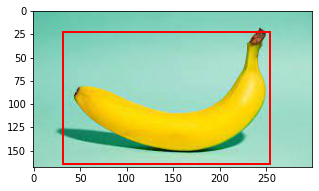

In [63]:
plot_img_bbox(img_to_array(load_img('../input/test121/download (2).jpg')),bb)

In [64]:
def prediction(img_path):
    img = load_img(img_path) # this is a PIL image


    array = img_to_array(img)
    
    arrayresized = cv2.resize(array, (224,224))


    inputarray = arrayresized[np.newaxis,...] # dimension added to fit input size

    prediction = model.predict(inputarray)  
    
    label=classes[np.argmax(prediction[0])]
    xmin=prediction[1][0][0]*300
    ymin=prediction[1][0][1]*168
    xmax=prediction[1][0][2]*300
    ymax=prediction[1][0][3]*168
    bb=[xmin,ymin,xmax,ymax]
    plot_img_bbox(img,bb)
    
    

    
    

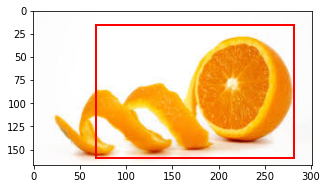

In [65]:
prediction('../input/test121/orange.jpg')